In [70]:
import matplotlib.pyplot as plt
import os
import glob
import natsort
import pickle
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print("tf version =",tf.__version__)
from tensorflow.keras.models import Model
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors, Draw, MolFromSmarts
import cv2

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

tf version = 2.2.0-dev20200501


In [2]:
pickle_in = open('ESOL_random.pickle','rb')
ESOL = pickle.load(pickle_in)
ESOL.head()

Compound ID  ESOL predicted log solubility in mols per litre  \
164                RTI 3                                           -3.049   
907           2,4',5-PCB                                           -5.762   
386        aminothiazole                                           -1.226   
221   2,4-Dinitrotoluene                                           -2.604   
1069     o-Methoxyphenol                                           -1.941   

      Minimum Degree  Molecular Weight  Number of H-Bond Donors  \
164                1           255.277                        1   
907                1           257.547                        0   
386                1           100.146                        1   
221                1           182.135                        0   
1069               1           124.139                        1   

      Number of Rings  Number of Rotatable Bonds  Polar Surface Area  \
164                 3                          0               68.45   
907                 2                          1                0.00   
386                 1                          0               38.91   
221                 1                          2               86.28   
1069                1                          1               29.46   

      measured log solubility in mols per litre  \
164                                      -3.043   
907                                      -6.250   
386                                      -0.360   
221                                      -2.820   
1069                                     -1.960   

                                   smiles  
164   O2c1cc(C)ccc1N(C)C(=O)c3cc(N)cnc23   
907           Clc1ccc(cc1)c2cc(Cl)ccc2Cl   
386                             Nc1nccs1   
221             Cc1ccc(cc1N(=O)=O)N(=O)=O  
1069                          COc1ccccc1O

In [145]:
n = 0
n_max = len(ESOL)

Mw = []
HBA = []
HBD = []
HA = []
HB = []
y = []
func = []


while n < n_max:
    
    smi = ESOL.iloc[n,9]
    y.append(ESOL.iloc[n,8])

    mol = Chem.MolFromSmiles(smi)
    
    Mwn = Chem.Descriptors.ExactMolWt(mol)
    Mw.append(Mwn)
    
    HBAn = Chem.rdMolDescriptors.CalcNumHBA(mol)
    HBA.append(HBAn)
    
    HBDn = Chem.rdMolDescriptors.CalcNumHBD(mol)
    HBD.append(HBDn)
    
    HAn = Chem.rdMolDescriptors.CalcNumHeteroatoms(mol)
    HA.append(HAn)
    
    
    
    n += 1

    p = (n/n_max)*100
  
    if p == 10 or p==20 or p==30 or p==40 or p==50 or p==60 or p==70 or p==80 or p==90 or p==100:
        print (str(p) + " %")
        


Mw = np.array(Mw)
HA = np.array(HA) 
HBD = np.array(HBD) 
HBA = np.array(HBA)

X_full = np.array(np.column_stack((Mw/max(Mw),HBA/max(HBA),HBD/max(HBD),HA/max(HA))))
print(X_full.shape)
print(X_full)

y_full = np.array(y)

50.0 %
100.0 %
(1128, 4)
[[0.32687224 0.25       0.09090909 0.3125    ]
 [0.32797491 0.         0.         0.1875    ]
 [0.12814675 0.1875     0.09090909 0.1875    ]
 ...
 [0.19750118 0.0625     0.09090909 0.0625    ]
 [0.21777653 0.         0.         0.0625    ]
 [0.17431234 0.1875     0.18181818 0.3125    ]]


In [146]:
s = 0.9  #size in percent of training data from full data
train_size =round(len(X_full)*s)


X_train = X_full[:train_size]
X_test = X_full[train_size:]
y_train = y_full[:train_size]
y_test = y_full[train_size:]


print("X_train:",len(X_train),X_train.shape)
print("X_test:",len(X_test),X_test.shape)
print("y_train:",len(y_train))
print("y_test:",len(y_test))

X_train: 1015 (1015, 4)
X_test: 113 (113, 4)
y_train: 1015
y_test: 113


Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_56 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_57 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_58 (Dense)             (None, 1)                 3         
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________
None

Epoch: 0, loss:13.4662,  mae:3.0833,  mse:13.4653,  val_loss:13.5121,  val_mae:3.1311,  val_mse:13.5112,  
....................................................................................................
Epoch: 100, loss:6.2475,  mae:1.9356,  mse:6.2464,  val_loss:6.1131,  val_mae:1.8910,  val_mse:6.1121,  
....................................................................

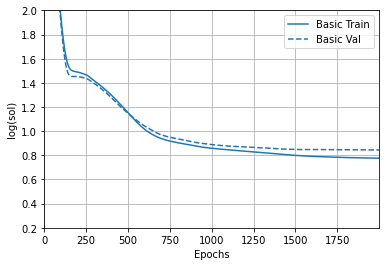

4/4 - 0s - loss: 1.0842 - mae: 0.7832 - mse: 1.0803
Testing set Mean Abs Error: +/-  0.78 mol/l


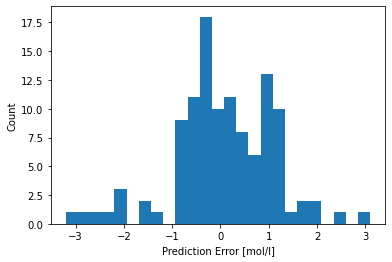

In [148]:
def build_model():
  model = keras.Sequential([
    layers.Dense(4, kernel_regularizer = keras.regularizers.l2(0.0001), activation='relu', input_shape=(4,)),
    layers.Dense(2, kernel_regularizer = keras.regularizers.l2(0.0001), activation='relu'),
    layers.Dense(1)
            ])

  
  

  optimizer = tf.keras.optimizers.Adam(0.0001)


  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model


model = build_model()

print(model.summary())

EPOCHS = 4000

history = model.fit(
  X_train, y_train,
  epochs = EPOCHS, validation_split = 0.1, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])


plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Basic': history}, metric = "mae")
plt.ylim([0.2, 2])
plt.ylabel('log(sol)')
plt.show()

loss, mae, mse = model.evaluate(X_test, y_test, verbose=2)

print("Testing set Mean Abs Error: +/- {:5.2f} mol/l".format(mae))

test_predictions = model.predict(X_test).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [mol/l]')
plt.ylabel('Predictions [mol/l]')
lims = [-7, 4]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.show()

error = test_predictions - y_test
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [mol/l]")
_ = plt.ylabel("Count")

plt.show()